# Entity Service Similarity Scores Output

This tutorial demonstrates generating CLKs from PII, creating a new project on the entity service, and how to retrieve the results. 
The output type is raw similarity scores. This output type is particularly useful for determining a good threshold for the greedy solver used in mapping.

The sections are usually run by different participants - but for illustration all is carried out in this one file. The participants providing data are *Alice* and *Bob*, and the analyst is acting as the integration authority.

### Who learns what?

Alice and Bob will both generate and upload their CLKs.

The analyst - who creates the linkage project - learns the `similarity scores`. Be aware that this is a lot of information and are subject to frequency attacks.

### Steps

* Check connection to Entity Service
* Data preparation
  * Write CSV files with PII
  * Create a Linkage Schema
* Create Linkage Project
* Generate CLKs from PII
* Upload the PII
* Create a run
* Retrieve and analyse results

In [1]:
%matplotlib inline

import json
import os
import time
import pandas as pd

import matplotlib.pyplot as plt
import requests
import clkhash.rest_client
from IPython.display import clear_output

## Check Connection

If you are connecting to a custom entity service, change the address here.

In [2]:
url = os.getenv("SERVER", "https://testing.es.data61.xyz")
print(f'Testing anonlink-entity-service hosted at {url}')

Testing anonlink-entity-service hosted at http://0.0.0.0:8851


In [3]:
!clkutil status --server "{url}"

{"project_count": 4, "rate": 32036360, "status": "ok"}


## Data preparation

Following the [clkhash tutorial](http://clkhash.readthedocs.io/en/latest/tutorial_cli.html) we will use a dataset from the `recordlinkage` library. We will just write both datasets out to temporary CSV files.

If you are following along yourself you may have to adjust the file names in all the `!clkutil` commands.

In [4]:
from tempfile import NamedTemporaryFile
from recordlinkage.datasets import load_febrl4

In [5]:
dfA, dfB = load_febrl4()

a_csv = NamedTemporaryFile('w')
a_clks = NamedTemporaryFile('w', suffix='.json')
dfA.to_csv(a_csv)
a_csv.seek(0)

b_csv = NamedTemporaryFile('w')
b_clks = NamedTemporaryFile('w', suffix='.json')
dfB.to_csv(b_csv)
b_csv.seek(0)

dfA.head(3)

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-1070-org,michaela,neumann,8,stanley street,miami,winston hills,4223,nsw,19151111,5304218
rec-1016-org,courtney,painter,12,pinkerton circuit,bega flats,richlands,4560,vic,19161214,4066625
rec-4405-org,charles,green,38,salkauskas crescent,kela,dapto,4566,nsw,19480930,4365168


## Schema Preparation

The linkage schema must be agreed on by the two parties. A hashing schema instructs clkhash how to treat each column for generating CLKs. A detailed description of the hashing schema can be found in the api docs. We will ignore the columns `rec_id` and `soc_sec_id` for CLK generation.

In [6]:
schema = NamedTemporaryFile('wt')

In [7]:
%%writefile {schema.name}
{
  "version": 3,
  "clkConfig": {
    "l": 1024,
    "xor_folds": 0,
    "kdf": {
      "type": "HKDF",
      "hash": "SHA256",
      "info": "c2NoZW1hX2V4YW1wbGU=",
      "salt": "SCbL2zHNnmsckfzchsNkZY9XoHk96P/G5nUBrM7ybymlEFsMV6PAeDZCNp3rfNUPCtLDMOGQHG4pCQpfhiHCyA==",
      "keySize": 64
    }
  },
  "features": [
    {
      "identifier": "rec_id",
      "ignored": true
    },
    {
      "identifier": "given_name",
      "format": {
        "type": "string",
        "encoding": "utf-8"
      },
      "hashing": {
        "strategy": {
          "bitsPerFeature": 200
        },
        "hash": {
          "type": "doubleHash"
        },
        "comparison": {
          "type": "ngram",
          "n": 2,
          "positional": false
        }
      }
    },
    {
      "identifier": "surname",
      "format": {
        "type": "string",
        "encoding": "utf-8"
      },
      "hashing": {
        "strategy": {
          "bitsPerFeature": 200
        },
        "hash": {
          "type": "doubleHash"
        },
        "comparison": {
          "type": "ngram",
          "n": 2,
          "positional": false
        }
      }
    },
    {
      "identifier": "street_number",
      "format": {
        "type": "integer"
      },
      "hashing": {
        "missingValue": {
          "sentinel": ""
        },
        "strategy": {
          "bitsPerFeature": 100
        },
        "hash": {
          "type": "doubleHash"
        },
        "comparison": {
          "type": "ngram",
          "n": 1,
          "positional": true
        }
      }
    },
    {
      "identifier": "address_1",
      "format": {
        "type": "string",
        "encoding": "utf-8"
      },
      "hashing": {
        "strategy": {
          "bitsPerFeature": 100
        },
        "hash": {
          "type": "doubleHash"
        },
        "comparison": {
          "type": "ngram",
          "n": 2,
          "positional": false
        }
      }
    },
    {
      "identifier": "address_2",
      "format": {
        "type": "string",
        "encoding": "utf-8"
      },
      "hashing": {
        "strategy": {
          "bitsPerFeature": 100
        },
        "hash": {
          "type": "doubleHash"
        },
        "comparison": {
          "type": "ngram",
          "n": 2,
          "positional": false
        }
      }
    },
    {
      "identifier": "suburb",
      "format": {
        "type": "string",
        "encoding": "utf-8"
      },
      "hashing": {
        "strategy": {
          "bitsPerFeature": 100
        },
        "hash": {
          "type": "doubleHash"
        },
        "comparison": {
          "type": "ngram",
          "n": 2,
          "positional": false
        }
      }
    },
    {
      "identifier": "postcode",
      "format": {
        "type": "integer",
        "minimum": 100,
        "maximum": 9999
      },
      "hashing": {
        "strategy": {
          "bitsPerFeature": 100
        },
        "hash": {
          "type": "doubleHash"
        },
        "comparison": {
          "type": "ngram",
          "n": 1,
          "positional": true
        }
      }
    },
    {
      "identifier": "state",
      "format": {
        "type": "string",
        "encoding": "utf-8",
        "maxLength": 3
      },
      "hashing": {
        "strategy": {
          "bitsPerFeature": 100
        },
        "hash": {
          "type": "doubleHash"
        },
        "comparison": {
          "type": "ngram",
          "n": 2,
          "positional": false
        }
      }
    },
    {
      "identifier": "date_of_birth",
      "format": {
        "type": "integer"
      },
      "hashing": {
        "missingValue": {
          "sentinel": ""
        },
        "strategy": {
          "bitsPerFeature": 200
        },
        "hash": {
          "type": "doubleHash"
        },
        "comparison": {
          "type": "ngram",
          "n": 1,
          "positional": true
        }
      }
    },
    {
      "identifier": "soc_sec_id",
      "ignored": true
    }
  ]
}

Overwriting /tmp/tmp23q54lqu


## Create Linkage Project

The analyst carrying out the linkage starts by creating a linkage project of the desired output type with the Entity Service.


In [8]:
creds = NamedTemporaryFile('wt')
print("Credentials will be saved in", creds.name)

!clkutil create-project \
    --schema "{schema.name}" \
    --output "{creds.name}" \
    --type "similarity_scores" \
    --server "{url}"

creds.seek(0)

with open(creds.name, 'r') as f:
    credentials = json.load(f)

project_id = credentials['project_id']
credentials

Credentials will be saved in /tmp/tmp6c2zwr2b
Project created


{'project_id': '4d499f0fd3fb41c7dca684ee923ee056daff1d1d0dea0e69',
 'result_token': '644530073d94cec15ee0b6955192e6ec66e4d5b6a7c59ec4',
 'update_tokens': ['aaec135b6729e8234b2d974e99b47df48a5d2b83b1e0e5fb',
  'f154012b6f6d48700490f964525633ff8efaa18f200ec7c5']}

**Note:** the analyst will need to pass on the `project_id` (the id of the linkage project) and one of the two `update_tokens` to each data provider.

## Hash and Upload

At the moment both data providers have *raw* personally identiy information. We first have to generate CLKs from the raw entity information. Please see [clkhash](https://clkhash.readthedocs.io/) documentation for further details on this.

In [9]:
!clkutil hash "{a_csv.name}" secret "{schema.name}" "{a_clks.name}"
!clkutil hash "{b_csv.name}" secret "{schema.name}" "{b_clks.name}"

CLK data written to /tmp/tmp75ho6ywb.json
CLK data written to /tmp/tmp1rw5bksd.json


Now the two clients can upload their data providing the appropriate *upload tokens*.

### Alice uploads her data

In [10]:
with NamedTemporaryFile('wt') as f:
    !clkutil upload \
        --project="{project_id}" \
        --apikey="{credentials['update_tokens'][0]}" \
        --server "{url}" \
        --output "{f.name}" \
        "{a_clks.name}"
    res = json.load(open(f.name))
    alice_receipt_token = res['receipt_token']

Every upload gets a receipt token. In some operating modes this receipt is required to access the results.

### Bob uploads his data

In [11]:
with NamedTemporaryFile('wt') as f:
    !clkutil upload \
        --project="{project_id}" \
        --apikey="{credentials['update_tokens'][1]}" \
        --server "{url}" \
        --output "{f.name}" \
        "{b_clks.name}"
    
    bob_receipt_token = json.load(open(f.name))['receipt_token']

## Create a run

Now the project has been created and the CLK data has been uploaded we can carry out some privacy preserving record linkage. Try with a few different threshold values:

In [12]:
with NamedTemporaryFile('wt') as f:
    !clkutil create \
        --project="{project_id}" \
        --apikey="{credentials['result_token']}" \
        --server "{url}" \
        --threshold 0.75 \
        --output "{f.name}"
    
    run_id = json.load(open(f.name))['run_id']

## Results

Now after some delay (depending on the size) we can fetch the result.
This can be done with clkutil:

    !clkutil results --server "{url}" \
        --project="{credentials['project_id']}" \
        --apikey="{credentials['result_token']}" --output results.txt
        
However for this tutorial we are going to use the `clkhash` library:

In [13]:
from clkhash.rest_client import RestClient
from clkhash.rest_client import format_run_status
rest_client = RestClient(url)
for update in rest_client.watch_run_status(project_id, run_id, credentials['result_token'], timeout=300):
    clear_output(wait=True)
    print(format_run_status(update))

State: completed
Stage (2/2): compute similarity scores
Progress: 100.00%


In [14]:
data = json.loads(rest_client.run_get_result_text(
    project_id, 
    run_id, 
    credentials['result_token']))['similarity_scores']

This result is a large list of tuples recording the similarity between all rows above the given threshold.

In [15]:
for row in data[:10]:
    print(row)

[[0, 76], [1, 2345], 1.0]
[[0, 83], [1, 3439], 1.0]
[[0, 103], [1, 863], 1.0]
[[0, 154], [1, 2391], 1.0]
[[0, 177], [1, 4247], 1.0]
[[0, 192], [1, 1176], 1.0]
[[0, 270], [1, 4516], 1.0]
[[0, 312], [1, 1253], 1.0]
[[0, 407], [1, 3743], 1.0]
[[0, 670], [1, 3550], 1.0]


Note there can be a lot of similarity scores:

In [16]:
len(data)

280116

We will display a *sample* of these similarity scores in a histogram using matplotlib:

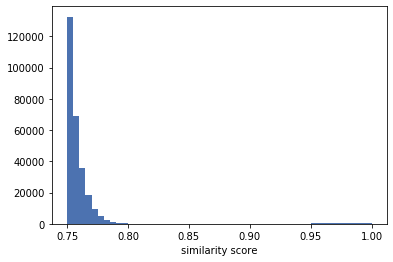

In [17]:
plt.style.use('seaborn-deep')
plt.hist([score for _, _, score in data], bins=50)
plt.xlabel('similarity score')
plt.show()

The vast majority of these similarity scores are for non matches. We expect the matches to have a high similarity score. So let's zoom into the right side of the distribution.

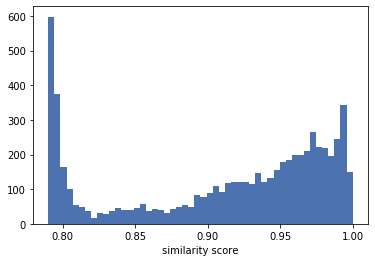

In [18]:
plt.hist([score for _, _, score in data if score >= 0.79], bins=50);
plt.xlabel('similarity score')
plt.show()

Indeed, there is a cluster of scores between 0.9 and 1.0. To better visualize that these are indeed the scores for the matches, we will now extract the true_matches from the datasets and group the similarity scores into those for the matches and the non-matches (We can do this because we know the ground truth of the dataset).

In [19]:
# rec_id in dfA has the form 'rec-1070-org'. We only want the number. Additionally, as we are
# interested in the position of the records, we create a new index which contains the row numbers.
dfA_ = dfA.rename(lambda x: x[4:-4], axis='index').reset_index()
dfB_ = dfB.rename(lambda x: x[4:-6], axis='index').reset_index()
# now we can merge dfA_ and dfB_ on the record_id.
a = pd.DataFrame({'ida': dfA_.index, 'rec_id': dfA_['rec_id']})
b = pd.DataFrame({'idb': dfB_.index, 'rec_id': dfB_['rec_id']})
dfj = a.merge(b, on='rec_id', how='inner').drop(columns=['rec_id'])
# and build a set of the corresponding row numbers.
true_matches = set((row[0], row[1]) for row in dfj.itertuples(index=False))

In [21]:
scores_matches = []
scores_non_matches = []
for (_, a), (_, b), score in data:
    if score < 0.79:
        continue
    if (a, b) in true_matches:
        scores_matches.append(score)
    else:
        scores_non_matches.append(score)

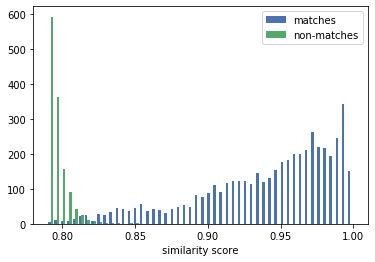

In [22]:
plt.hist([scores_matches, scores_non_matches], bins=50, label=['matches', 'non-matches'])
plt.legend(loc='upper right')
plt.xlabel('similarity score')
plt.show()

We can see that the similarity scores for the matches and the ones for the non-matches form two different distributions. With a suitable linkage schema, these two distributions hardly overlap. 

When choosing a similarity threshold for solving, the valley between these two distributions is a good starting point. In this example, it is around 0.82. We can see that almost all similarity scores above 0.82 are from matches, thus the solver will produce a linkage result with high precision. However, recall will not be optimal, as there are still some scores from matches below 0.82. By moving the threshold to either side, you can favour either precision or recall.

In [23]:
# Deleting the project
!clkutil delete-project --project="{credentials['project_id']}" \
        --apikey="{credentials['result_token']}" \
        --server="{url}"

Project deleted
